## Attempt to replicate http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture16.pdf, slide 11

Using both a random and adversarial direction, scores were highly nonlinear. Failed to replicate result.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

from resnet import *
from vgg import *

In [3]:
transform_normalize = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = dset.CIFAR10('./dataset', train=True, download=True,
                       transform=transform_normalize)
trainloader = DataLoader(trainset, batch_size=20, shuffle=True)

Files already downloaded and verified


In [4]:
# model = ResNet18()
model = VGG('VGG11')

In [5]:
param_count = 0
for param in model.parameters():
    param.requires_grad = False
    param_count += np.prod(param.size())
print(param_count)

9231114


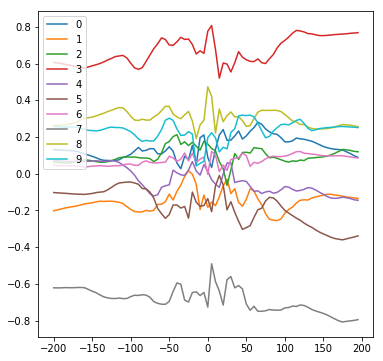

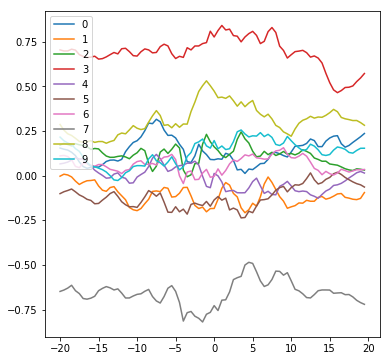

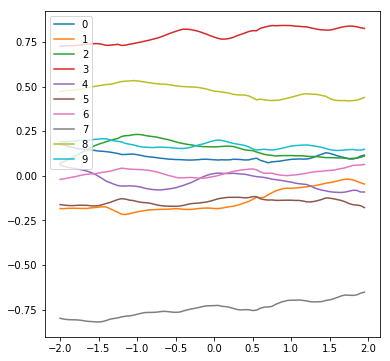

In [6]:
# random direction
img = torch.FloatTensor(images[5:6])
img_var = Variable(img, requires_grad=True)

# scores = model(img_var)
# objective = scores.squeeze()[4]
# objective.backward()
# g = img_var.grad.data
g = torch.FloatTensor(np.random.randn(32, 32))
g = g / g.norm()

def plot_interpolation(X, img=img, img_var=img_var):
    Y = []
    plt.figure(figsize=(6, 6))
    for i in range(10):
        Y.append([])
        for x in X:
            img += x * g
            scores = model(img_var)
            img -= x * g
            y = scores.squeeze().data[i]
            Y[i].append(y)
        plt.plot(X, Y[i], label=str(i))
    plt.legend(loc='upper left')
    plt.show()

plot_interpolation(np.arange(-200, 200, 5))
plot_interpolation(np.arange(-20, 20, .5))
plot_interpolation(np.arange(-2, 2, .05))

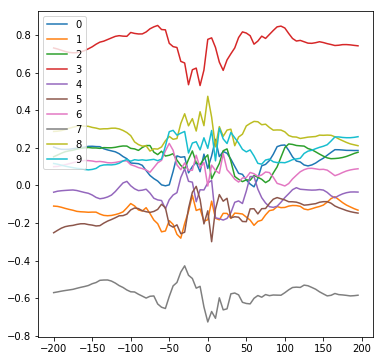

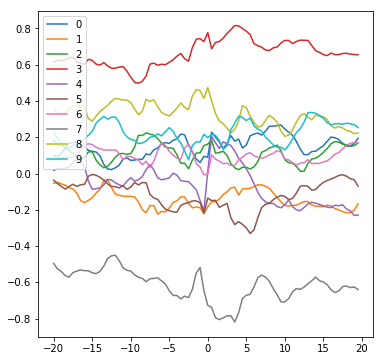

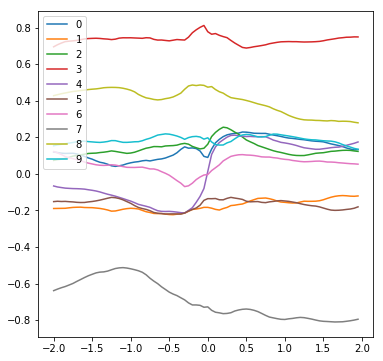

In [7]:
# adversarial
img = torch.FloatTensor(images[5:6])
img_var = Variable(img, requires_grad=True)

scores = model(img_var)
objective = scores.squeeze()[4]
objective.backward()
g = img_var.grad.data
# g = torch.FloatTensor(np.random.randn(32, 32))
g = g / g.norm()

def plot_interpolation(X, img=img, img_var=img_var):
    Y = []
    plt.figure(figsize=(6, 6))
    for i in range(10):
        Y.append([])
        for x in X:
            img += x * g
            scores = model(img_var)
            img -= x * g
            y = scores.squeeze().data[i]
            Y[i].append(y)
        plt.plot(X, Y[i], label=str(i))
    plt.legend(loc='upper left')
    plt.show()

plot_interpolation(np.arange(-200, 200, 5))
plot_interpolation(np.arange(-20, 20, .5))
plot_interpolation(np.arange(-2, 2, .05))